<a href="https://colab.research.google.com/github/r0c10/DataScience/blob/master/Tarea_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [87]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [88]:
fashion_mnist = keras.datasets.fashion_mnist

In [89]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

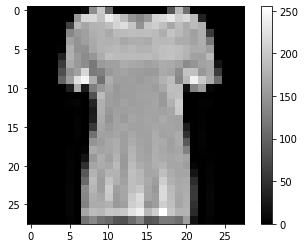

In [90]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [91]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

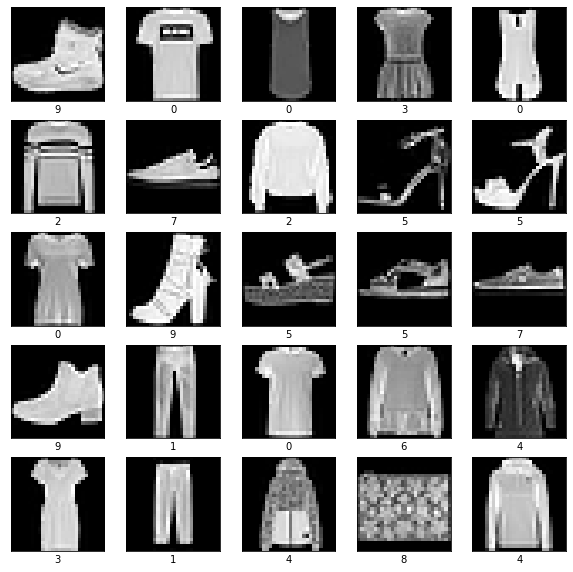

In [92]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [93]:
# Filtrando datos
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names_split = ['Dress','Sandal','Bag']

In [98]:
index_train = np.where((train_labels == 3) | (train_labels == 5) | (train_labels == 8))
train_labels_split = train_labels[index_train]
train_images_split = train_images[index_train]

index_test = np.where((test_labels == 3) | (test_labels == 5) | (test_labels == 8))
test_labels_split = test_labels[index_test]
test_images_split = test_images[index_test]

In [99]:
image_size = 28
num_labels = 3

def NormalizedData(df, var_names):
    df = df.reshape((-1, image_size * image_size)).astype(np.float32)
    data_normalized = df/255.0
    variable_names = pd.DataFrame(var_names)
    labels_df = np.array(pd.get_dummies(variable_names[0]))
    return df, data_normalized, labels_df

In [100]:
train_dataset, train_normalized, train_labels = NormalizedData(train_images_split, train_labels_split)
test_dataset, test_normalized, test_labels = NormalizedData(test_images_split, test_labels_split)

In [101]:
def accuracy(predictions, labels):
    with graph.as_default() as g:
        acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(labels, 1), 
                                      predictions=tf.argmax(predictions,1),name="accuracy")
        return acc_op

In [102]:
graph = tf.Graph()
 
with graph.as_default() as g:
  xtr = tf.placeholder(tf.float32, shape=None, name="X")
  ytr = tf.placeholder(tf.float32,None,"Y")
  xte = tf.placeholder(tf.float32,shape=None, name="X_test")
  yte = tf.placeholder(tf.float32, shape=None, name="Y_test")

  tf.set_random_seed(250)
  W = weights = tf.Variable(
  tf.truncated_normal([image_size * image_size, num_labels]))
  
  with tf.name_scope("Logits") as scope:
    logits = tf.matmul(xtr, W,name="logits")

  with tf.name_scope("Loss") as scope:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=ytr,logits= logits),name="loss")

  with tf.name_scope("Gradient") as scope:
    gradiente = tf.gradients(loss,W,name="gradient")[0]

  with tf.name_scope("Predictions") as scope:
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(xte, W))

  with tf.name_scope("Accurracy") as scope:
    training_accurracy = accuracy(train_prediction,ytr)
    test_accurracy = accuracy(test_prediction,yte)

In [47]:
import datetime
def run_training(X,Y,XT,YT,epochs,batch_size,lr,writer_name):
    loss_plt = []
    iteraciones = int(len(X)/batch_size)
    with graph.as_default() as g:
        
        with tf.name_scope("update") as scope:
            update_params = tf.assign(W,W - gradiente * lr,name="update_param")
        
        scalar = tf.summary.scalar('loss graph', loss)
        with tf.train.MonitoredSession() as sess:
            writer = tf.summary.FileWriter('./logs/'+datetime.datetime.now().strftime("%Y%m%d-%H")+str(writer_name), sess.graph)
            for e in range(epochs):
                for i in range(iteraciones):
                    offset = (e * batch_size) % (Y.shape[0] - batch_size)
                    batch_data = X[offset:(offset + batch_size), :]
                    batch_labels = Y[offset:(offset + batch_size), :]
                    feed_dict = {xtr : batch_data, ytr : batch_labels}
                    u, predictions = sess.run([update_params,train_prediction],feed_dict=feed_dict)
                feed_dict = {xtr: X, ytr: Y}
                l = sess.run(loss,feed_dict)
                loss_plt.append(l)
                summary = sess.run(scalar,feed_dict)
                writer.add_summary(summary, (e+1))
                if e % 100 == 0:
                    print("loss at step %d: %f" % (e, l))
                    print("Training accuracy: %.3f%%" % sess.run(training_accurracy,feed_dict))
            feed_dict = {xte:XT,yte:YT}
            print("Test accuracy: %.3f%%" % sess.run(test_accurracy,feed_dict))
            plt.plot(loss_plt)
            return sess.run(test_prediction,feed_dict),sess.run(W)

INFO:tensorflow:Summary name loss graph is illegal; using loss_graph instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 1725.574829
Training accuracy: 0.217%
loss at step 100: 104.430267
Training accuracy: 0.549%
loss at step 200: 66.297943
Training accuracy: 0.674%
loss at step 300: 56.303242
Training accuracy: 0.739%
loss at step 400: 50.443325
Training accuracy: 0.780%
loss at step 500: 44.863819
Training accuracy: 0.808%
loss at step 600: 41.256397
Training accuracy: 0.829%
loss at step 700: 39.542988
Training accuracy: 0.845%
loss at step 800: 38.266777
Training accuracy: 0.857%
loss at step 900: 38.246193
Training accuracy: 0.867%
Test accuracy: 0.959%


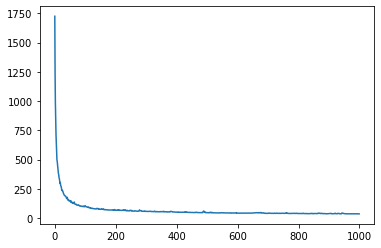

In [103]:
preds = run_training(train_dataset,train_labels,test_dataset,test_labels,1000,32,0.0000009,'sin_escalar')

In [104]:
predictions = preds[0]
params_w = preds[1]

In [115]:
def Index_Preds(image,W):
    test_prediction = tf.nn.softmax(tf.matmul(image, W))
    index = tf.math.argmax(test_prediction[0])
    with tf.train.MonitoredSession() as sess:
        return(sess.run(index))

In [116]:
def Image_Graph(idx_image,model,data_set,normalize = False):
    image = data_set[idx_image]
    r_image = image.reshape((-1, 28 * 28)).astype(np.float32)
    pred = class_names_split[Index_Preds(r_image,model)] 
    return image,pred

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


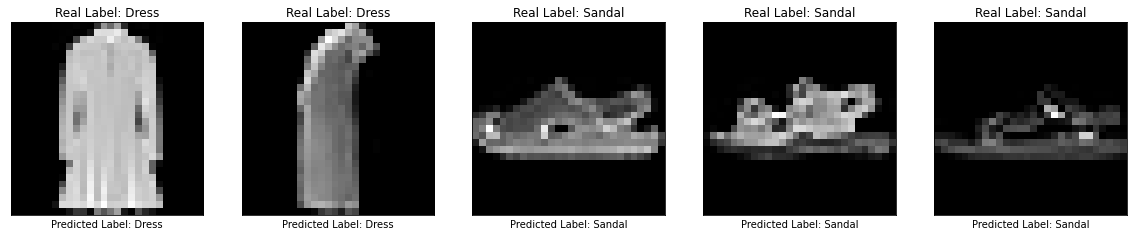

In [117]:
#seleccionando images al lazar, 5 
prueba = [5,90,225,320,500]
plt.figure(figsize=(20,20))
for i in range(5):
    img = Image_Graph(prueba[i],params_w,test_images_split)
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[0], cmap='gray')
    plt.xlabel('Predicted Label: '+img[1])
    plt.title('Real Label: '+class_names[test_labels_split[prueba[i]]])
plt.show()

INFO:tensorflow:Summary name loss graph is illegal; using loss_graph instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 5.656752
Training accuracy: 0.287%
loss at step 100: 0.328599
Training accuracy: 0.604%
loss at step 200: 0.220409
Training accuracy: 0.719%
loss at step 300: 0.184481
Training accuracy: 0.778%
loss at step 400: 0.168156
Training accuracy: 0.815%
Test accuracy: 0.966%


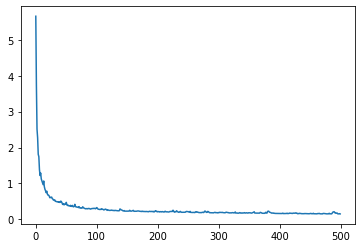

In [118]:
pred2 = run_training(train_normalized,train_labels,test_normalized,test_labels,500,32,0.0005,'escalado')

In [119]:
predictions_n = pred2[0]
params_w_n = pred2[1]

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


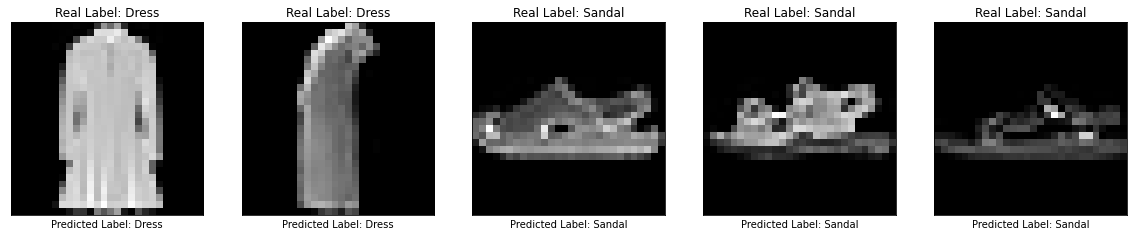

In [120]:
#probando con los datos normalizados
plt.figure(figsize=(20,20))
for i in range(5):
    img = graphImage(prueba[i],params_w_n,test_images_split)
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[0], cmap='gray')
    plt.xlabel('Predicted Label: '+img[1])
    plt.title('Real Label: '+class_names[test_labels_split[prueba[i]]])
plt.show()

**Imágenes de Tensorboard**

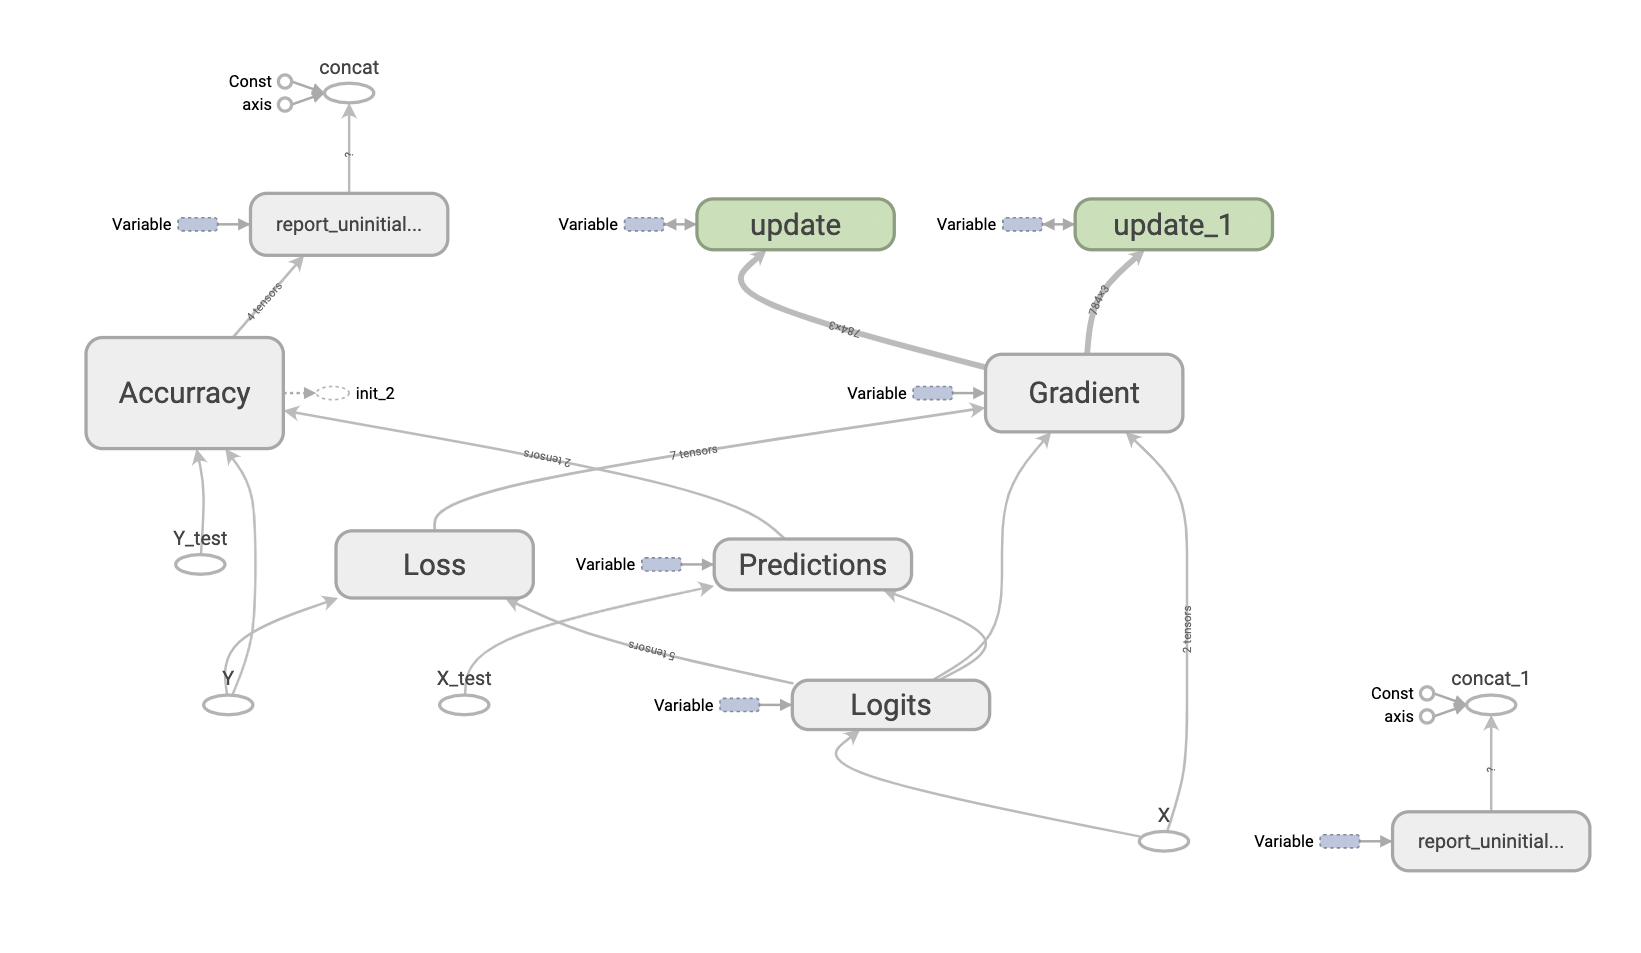

In [124]:
from IPython.display import Image
Image("Main_Graph.png")

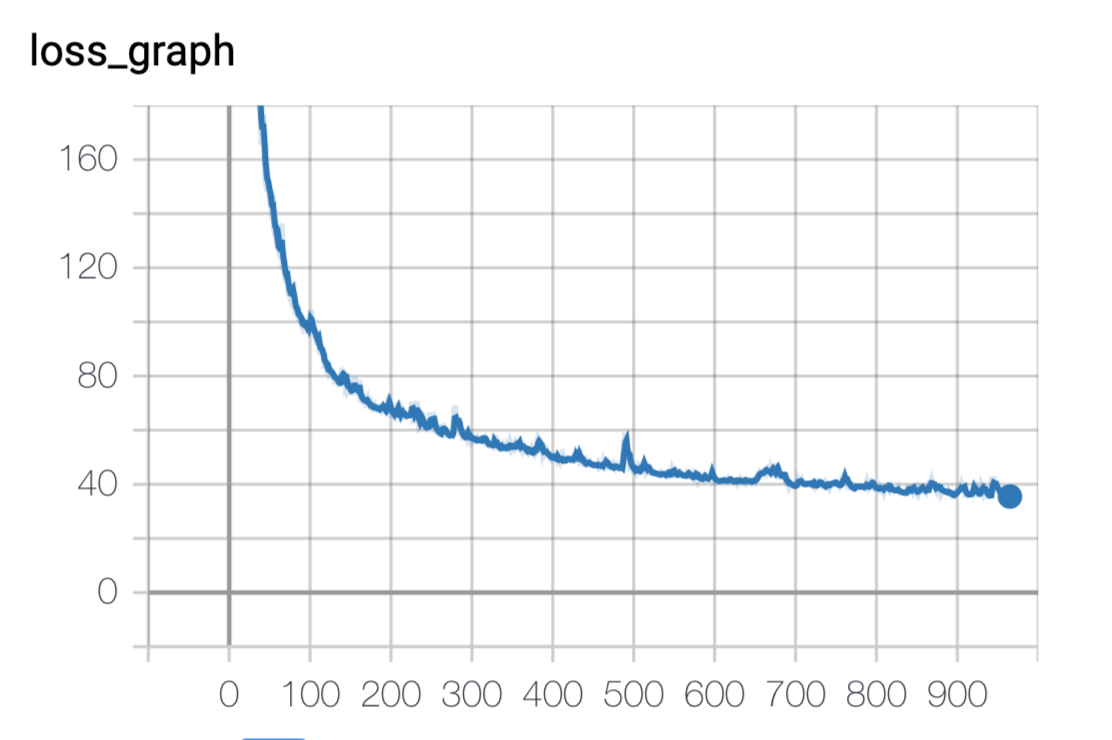

In [126]:
from IPython.display import Image
Image("Loss.png")

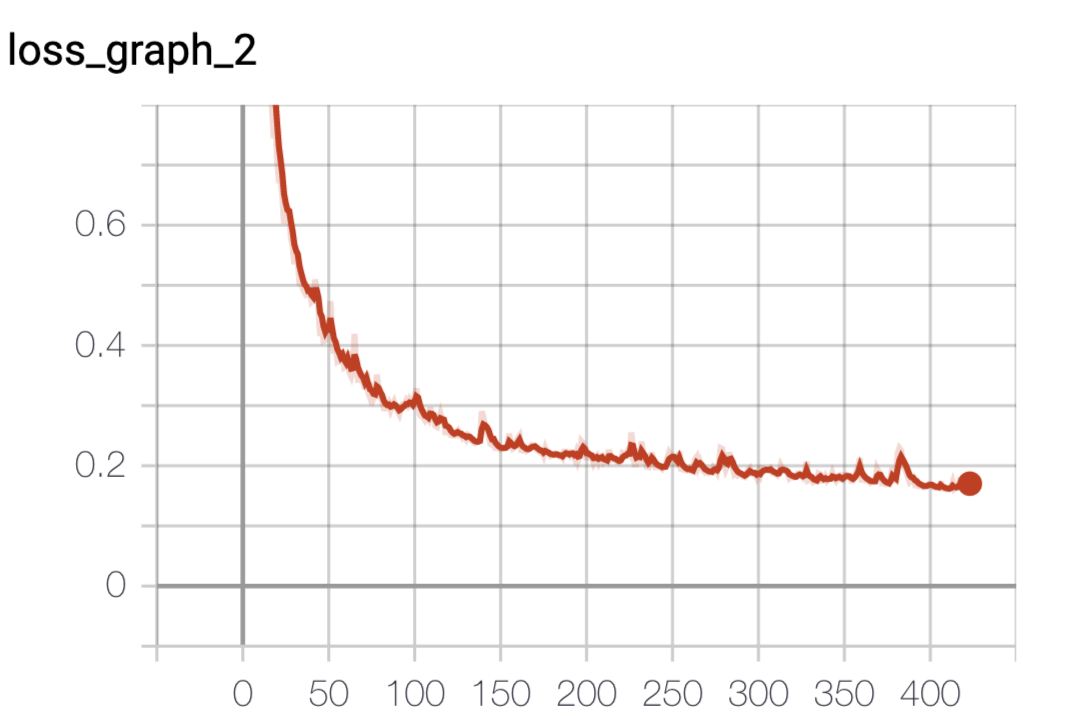

In [128]:
from IPython.display import Image
Image("Loss_2.png")

**A modo de conclusión se puede decir que:**

* Con los datos sin escalar obtenemos accurracy de 0.959%, con el error mínimo, el comportamiento del error es casi inestable, se obtuvo todos los nombres de cada prenda correctamente.

* Con los datos escalados obtenemos accurracy de 0.966% con la mitad de iteraciones anteriores, aunque con el error mínimo, en ciertos puntos el error se observa un poco inestable, el mismo termina convergiendo.

En ambos casos se obtiene una presición muy buena para los datos de prueba, si embargo al comparar los performance; los datos escalados funcionan mejor, ya que se obtuvo una mayor accuracy, con la mitad de iteraciones que los datos sin escalar.